# Label side

In [1]:
import numpy as np
from jesse import helpers, research

_, candles = research.get_candles(
    "Binance Perpetual Futures",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-07-15"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

candles.shape

(2911680, 6)

In [2]:
np.save("data/btc_1m.npy", candles)

In [3]:
import numpy as np

candles = np.load("data/btc_1m.npy")
candles.shape

(2882880, 6)

In [4]:
from scipy import stats
from custom_indicators.toolbox.bar.fusion.v0 import FusionBarContainerV0

bar_container = FusionBarContainerV0(max_bars=500000)
bar_container.update_with_candles(candles)
merged_bar = bar_container.get_fusion_bars()
close_arr = merged_bar[:, 2]
ret = np.log(close_arr[1:] / close_arr[:-1])
standard = (ret - ret.mean()) / ret.std()
kurtosis = stats.kurtosis(standard, axis=None, fisher=False, nan_policy="omit")
kurtosis

14.139429580927407

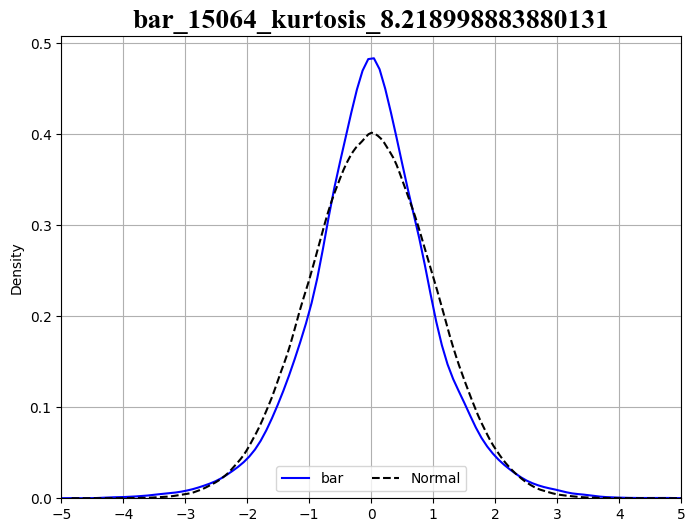

In [5]:
from custom_indicators.utils.plot import plot_kde

L = 5

plot_kde(merged_bar[:, 2], lag=L)

In [6]:
from hmmlearn.hmm import GMMHMM
import pandas as pd
import optuna

from jesse.helpers import timestamp_to_time


def objective(trial: optuna.Trial):
    mix = 3  ### GMM mix参数

    close_arr = merged_bar[:, 2]
    high_arr = merged_bar[:, 3][L:]
    low_arr = merged_bar[:, 4][L:]

    log_return = np.log(close_arr[1:] / close_arr[:-1])[L - 1 :]
    log_return_L = np.log(close_arr[L:] / close_arr[:-L])
    HL_diff = np.log(high_arr / low_arr)

    X = np.column_stack([HL_diff, log_return_L, log_return])

    datelist = np.asarray(
        [pd.Timestamp(timestamp_to_time(i)) for i in merged_bar[:, 0][L:]]
    )
    closeidx = merged_bar[:, 2][L:]

    assert len(datelist) == len(closeidx)
    assert len(datelist) == len(X)

    gmm = GMMHMM(
        n_components=2,
        n_mix=mix,
        covariance_type="diag",
        n_iter=1000,
        # weights_prior=2,
        means_weight=0.5,
        random_state=trial.suggest_int("random_state", 0, 1000),
    )
    gmm.fit(X)
    latent_states_sequence = gmm.predict(X)
    data = pd.DataFrame(
        {
            "datelist": datelist,
            "logreturn": log_return,
            "state": latent_states_sequence,
        }
    ).set_index("datelist")

    final_ret = 0
    for i in data["state"].unique():
        ret = data[data["state"] == i]["logreturn"].sum()
        final_ret += np.abs(ret)

    return final_ret


study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(n_startup_trials=5),
)
study.optimize(objective, n_trials=10)

[I 2025-07-01 00:08:16,894] A new study created in memory with name: no-name-bccb7e95-7280-4c73-90f4-0c45f856a654
[I 2025-07-01 00:08:19,358] Trial 0 finished with value: 39.38521026324763 and parameters: {'random_state': 280}. Best is trial 0 with value: 39.38521026324763.
[I 2025-07-01 00:08:20,138] Trial 1 finished with value: 56.41211704876675 and parameters: {'random_state': 742}. Best is trial 1 with value: 56.41211704876675.
[I 2025-07-01 00:08:21,656] Trial 2 finished with value: 56.493690676809436 and parameters: {'random_state': 750}. Best is trial 2 with value: 56.493690676809436.
[I 2025-07-01 00:08:22,763] Trial 3 finished with value: 56.438795481370576 and parameters: {'random_state': 423}. Best is trial 2 with value: 56.493690676809436.
[I 2025-07-01 00:08:23,901] Trial 4 finished with value: 56.39501026190385 and parameters: {'random_state': 180}. Best is trial 2 with value: 56.493690676809436.
[I 2025-07-01 00:08:24,754] Trial 5 finished with value: 56.466795266972454 

In [7]:
study.best_params

{'random_state': 652}

In [8]:
from hmmlearn.hmm import GMMHMM  # noqa
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd  # noqa

from jesse.helpers import timestamp_to_time  # noqa

mix = 3  ### GMM mix参数

close_arr = merged_bar[:, 2]
high_arr = merged_bar[:, 3][L:]
low_arr = merged_bar[:, 4][L:]

log_return = np.log(close_arr[1:] / close_arr[:-1])[L - 1 :]
log_return_L = np.log(close_arr[L:] / close_arr[:-L])
HL_diff = np.log(high_arr / low_arr)

X = np.column_stack([HL_diff, log_return_L, log_return])

datelist = np.asarray(
    [pd.Timestamp(timestamp_to_time(i)) for i in merged_bar[:, 0][L:]]
)
closeidx = merged_bar[:, 2][L:]

assert len(datelist) == len(closeidx)
assert len(datelist) == len(X)

gmm = GMMHMM(
    n_components=2,
    n_mix=mix,
    covariance_type="diag",
    n_iter=1000,
    # weights_prior=2,
    means_weight=0.5,
    random_state=study.best_params["random_state"],
)
gmm.fit(X)
latent_states_sequence = gmm.predict(X)

print(np.unique(latent_states_sequence, return_counts=True))

fig = go.Figure()
colors = px.colors.qualitative.Plotly

for i in range(gmm.n_components):
    state = latent_states_sequence == i
    fig.add_trace(
        go.Scatter(
            x=datelist[state],
            y=closeidx[state],
            mode="markers",
            name=f"latent state {i}",
            marker=dict(color=colors[i % len(colors)], size=4),
        )
    )

fig.update_layout(
    title="隐含状态序列",
    xaxis_title="时间",
    yaxis_title="收盘价",
    # width=1400,
    # height=600,
    showlegend=True,
)

fig.show()

(array([0, 1]), array([9261, 5798]))


state 1 (5798) return: -2693.649134%
state 0 (9261) return: 2962.869260%


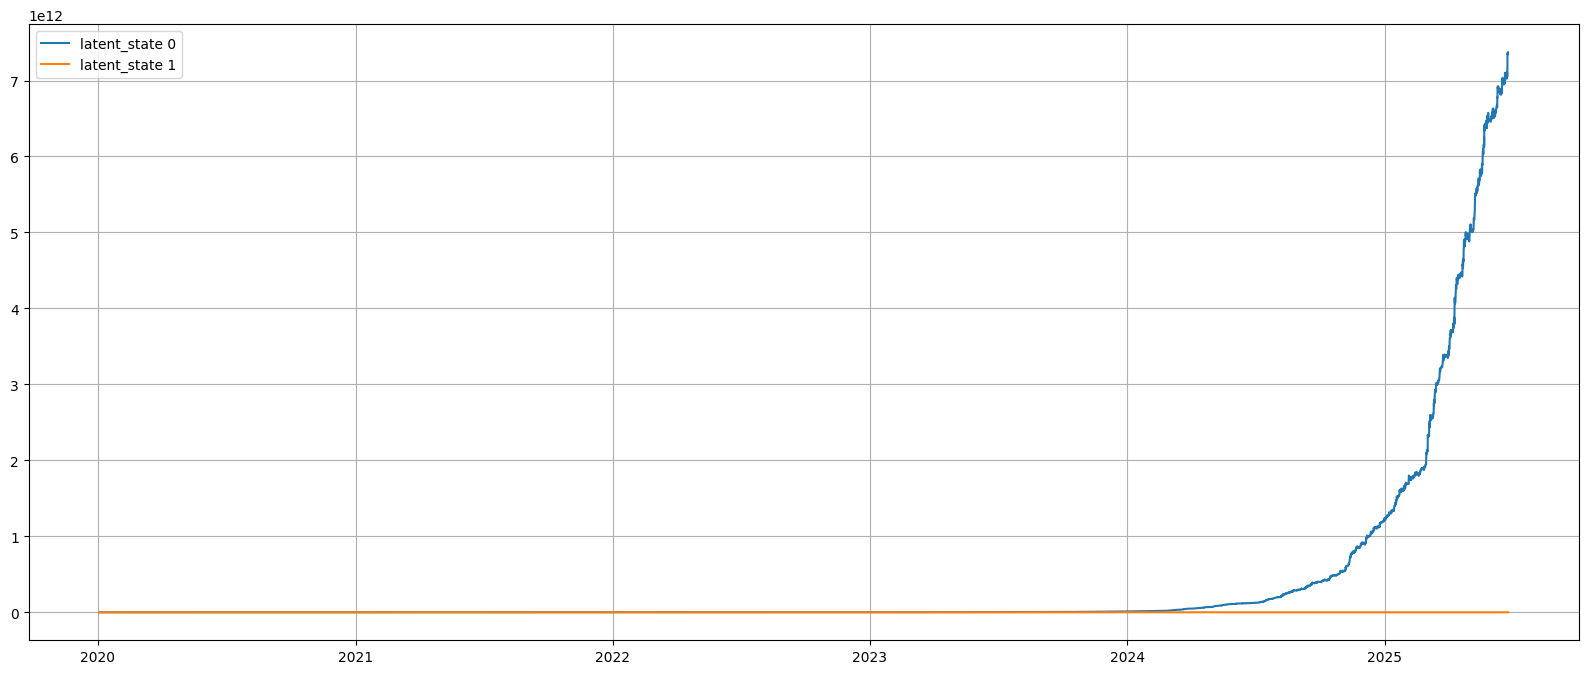

In [9]:
import matplotlib.pyplot as plt

data = pd.DataFrame(
    {
        "datelist": datelist,
        "logreturn": log_return,
        "state": latent_states_sequence,
    }
).set_index("datelist")

for i in data["state"].unique():
    ret = data[data["state"] == i]["logreturn"].sum()
    count = data[data["state"] == i].shape[0]
    print(f"state {i} ({count}) return: {ret:.6%}")

plt.figure(figsize=(20, 8))
for i in range(gmm.n_components):
    state = latent_states_sequence == i
    idx = np.append(0, state[1:])
    data["state %d_return" % i] = data.logreturn.multiply(idx, axis=0)
    plt.plot(np.exp(data["state %d_return" % i].cumsum()), label="latent_state %d" % i)
    plt.legend(loc="upper left")
    plt.grid(1)

In [10]:
assert len(merged_bar[L:]) == len(latent_states_sequence)
merged_bar.shape[0] - latent_states_sequence.shape[0] - 1

4

In [11]:
# 保存merged bar, 去除最后一个bar，因为需要label前移一位
print(merged_bar[:-1].shape)
np.save("data/merged_bar.npy", merged_bar[:-1])

(15063, 6)


In [12]:
# 上涨下跌统一打标的情况

label = (latent_states_sequence == 0).astype(int)
print(label.shape)
print(np.unique(label, return_counts=True))
np.save("data/side_label.npy", label)

(15059,)
(array([0, 1]), array([5798, 9261]))


In [ ]:
# 上涨下跌分别打标的情况

# label_long = (latent_states_sequence == 1).astype(int)
# print(np.unique(label_long, return_counts=True))
# np.save("data/side_label_long.npy", label_long)

# label_short = (latent_states_sequence == 0).astype(int)
# print(np.unique(label_short, return_counts=True))
# np.save("data/side_label_short.npy", label_short)

# Label meta

In [1]:
import numpy as np
import pandas as pd
from strategies.BinanceBtcEntropyBarV1.config import SIDE
from strategies.BinanceBtcEntropyBarV1.config import get_side_model

side_model = get_side_model(False)

merged_bar = np.load("data/merged_bar.npy")

df_features = pd.read_parquet("data/features.parquet")

side_res = side_model.predict(df_features[SIDE])

side_pred_label = np.where(side_res > 0.5, 1, -1)
print(side_pred_label.shape)

print(np.unique(side_pred_label, return_counts=True))

(13219,)
(array([-1,  1]), array([5080, 8139]))


In [2]:
close_prices = merged_bar[:, 2]
len_gap = len(close_prices) - len(side_pred_label)
close_prices = close_prices[len_gap - 1 : -1]

assert len(close_prices) == len(side_pred_label)

In [3]:
meta_label = np.zeros(len(side_pred_label))

TRADE_FEE = 0.05 / 100

start_idx = 0
cumsum_ret = 0
start_price = 0
for idx, (i, p) in enumerate(zip(side_pred_label, close_prices)):
    if i == 1 or i == -1:
        if idx == 0:
            # 开始持仓
            start_idx = idx
            start_price = p
            cumsum_ret -= TRADE_FEE
        elif side_pred_label[idx - 1] != i:
            # 反向持仓，先结算收益
            cumsum_ret -= TRADE_FEE
            cumsum_ret += np.log(p / start_price) * side_pred_label[idx - 1]
            if cumsum_ret > 0:
                meta_label[start_idx:idx] = 1
            cumsum_ret = 0
            start_price = p
            start_idx = idx
            cumsum_ret -= TRADE_FEE
        else:
            # 继续持仓
            continue
    else:
        raise ValueError(f"side_pred_label[{idx}] = {i} is not valid")
else:
    last_price = merged_bar[-1, 2]
    # 结算最后一根bar的持仓, 可能还没有结算，所以先不加trade fee
    if i == side_pred_label[idx - 1]:
        # 已经开仓，结算
        cumsum_ret += np.log(last_price / start_price) * side_pred_label[idx - 1]
        if cumsum_ret > 0:
            meta_label[start_idx:] = 1
    else:
        # 反向开仓
        cumsum_ret -= TRADE_FEE
        cumsum_ret += np.log(last_price / start_price) * side_pred_label[idx - 1]
        if cumsum_ret > 0:
            meta_label[start_idx:] = 1


print(np.unique(meta_label, return_counts=True))

(array([0., 1.]), array([  669, 12550]))


In [4]:
np.save("data/label_meta.npy", meta_label)